In [7]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  False
cpu


# Data import

In [45]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_DataSet.hdf5"
path_density = "./data/NKAS_density.hdf5"

f = h5py.File(path_data, 'r')
# Entropy dataset
X_entropy_train = f["X_entropy_train"].value
y_entropy_train = f["y_entropy_train"].value

X_entropy_valid = f["X_entropy_valid"].value
y_entropy_valid = f["y_entropy_valid"].value

X_entropy_test = f["X_entropy_test"].value
y_entropy_test = f["y_entropy_test"].value

# Viscosity dataset
X_train = f["X_train"].value
y_train = f["y_train"].value

X_valid = f["X_valid"].value
y_valid = f["y_valid"].value

X_test = f["X_test"].value
y_test = f["y_test"].value

# Tg dataset
X_tg_train = f["X_tg_train"].value
X_tg_valid= f["X_tg_valid"].value
X_tg_test = f["X_tg_test"].value

y_tg_train = f["y_tg_train"].value
y_tg_valid = f["y_tg_valid"].value
y_tg_test = f["y_tg_test"].value

f.close()

# Raman dataset
f = h5py.File(path_raman, 'r')
X_raman_train = f["X_raman_train"].value
y_raman_train = f["y_raman_train"].value
X_raman_valid = f["X_raman_test"].value
y_raman_valid = f["y_raman_test"].value
f.close()

# Density dataset
f = h5py.File(path_density, 'r')
X_density_train = f["X_density_train"].value
X_density_valid = f["X_density_valid"].value
X_density_test = f["X_density_test"].value

y_density_train = f["y_density_train"].value
y_density_valid = f["y_density_valid"].value
y_density_test = f["y_density_test"].value
f.close()

# grabbing number of Raman channels
nb_channels_raman = y_raman_valid.shape[1]

# preparing data

# viscosity
x_visco_train = torch.FloatTensor(X_train[:,0:4]).to(device)
T_visco_train = torch.FloatTensor(X_train[:,4].reshape(-1,1)).to(device)
y_visco_train = torch.FloatTensor(y_train[:,0].reshape(-1,1)).to(device)

x_visco_valid = torch.FloatTensor(X_valid[:,0:4]).to(device)
T_visco_valid = torch.FloatTensor(X_valid[:,4].reshape(-1,1)).to(device)
y_visco_valid = torch.FloatTensor(y_valid[:,0].reshape(-1,1)).to(device)

x_visco_test = torch.FloatTensor(X_test[:,0:4]).to(device)
T_visco_test = torch.FloatTensor(X_test[:,4].reshape(-1,1)).to(device)
y_visco_test = torch.FloatTensor(y_test[:,0].reshape(-1,1)).to(device)

# entropy
x_entro_train = torch.FloatTensor(X_entropy_train[:,0:4]).to(device)
y_entro_train = torch.FloatTensor(y_entropy_train[:,0].reshape(-1,1)).to(device)

x_entro_valid = torch.FloatTensor(X_entropy_valid[:,0:4]).to(device)
y_entro_valid = torch.FloatTensor(y_entropy_valid[:,0].reshape(-1,1)).to(device)

x_entro_test = torch.FloatTensor(X_entropy_test[:,0:4]).to(device)
y_entro_test = torch.FloatTensor(y_entropy_test[:,0].reshape(-1,1)).to(device)

# tg
x_tg_train = torch.FloatTensor(X_tg_train[:,0:4]).to(device)
y_tg_train = torch.FloatTensor(y_tg_train.reshape(-1,1)).to(device)

x_tg_valid = torch.FloatTensor(X_tg_valid[:,0:4]).to(device)
y_tg_valid = torch.FloatTensor(y_tg_valid.reshape(-1,1)).to(device)

x_tg_test = torch.FloatTensor(X_tg_test[:,0:4]).to(device)
y_tg_test = torch.FloatTensor(y_tg_test.reshape(-1,1)).to(device)

# Density
x_density_train = torch.FloatTensor(X_density_train[:,0:4]).to(device)
y_density_train = torch.FloatTensor(y_density_train.reshape(-1,1)).to(device)

x_density_valid = torch.FloatTensor(X_density_valid[:,0:4]).to(device)
y_density_valid = torch.FloatTensor(y_density_valid.reshape(-1,1)).to(device)

x_density_test = torch.FloatTensor(X_density_test[:,0:4]).to(device)
y_density_test = torch.FloatTensor(y_density_test.reshape(-1,1)).to(device)

# Raman
x_raman_train = torch.FloatTensor(X_raman_train[:,0:4]).to(device)
y_raman_train = torch.FloatTensor(y_raman_train).to(device)

x_raman_valid = torch.FloatTensor(X_raman_valid[:,0:4]).to(device)
y_raman_valid = torch.FloatTensor(y_raman_valid).to(device)


# Architecture experiment results

In [115]:
# List of networks
list_models = os.listdir("./model/exp_arch/")
nb_exp = len(list_models)

record_loss = pd.DataFrame()

record_loss["nb_layers"] = np.zeros(nb_exp)
record_loss["nb_neurons"] = np.zeros(nb_exp)
record_loss["p_drop"] = np.zeros(nb_exp)

record_loss["loss_ag_train"] = np.zeros(nb_exp)
record_loss["loss_ag_valid"] = np.zeros(nb_exp)
record_loss["loss_ag_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_am_train"] = np.zeros(nb_exp)
record_loss["loss_am_valid"] = np.zeros(nb_exp)
record_loss["loss_am_test"] = np.zeros(nb_exp)

record_loss["loss_Sconf_train"] = np.zeros(nb_exp)
record_loss["loss_Sconf_valid"] = np.zeros(nb_exp)
record_loss["loss_Sconf_test"] = np.zeros(nb_exp)

record_loss["loss_d_train"] = np.zeros(nb_exp)
record_loss["loss_d_valid"] = np.zeros(nb_exp)
record_loss["loss_d_test"] = np.zeros(nb_exp)

record_loss["loss_raman_train"] = np.zeros(nb_exp)
record_loss["loss_raman_valid"] = np.zeros(nb_exp)

# Loss criterion
criterion = torch.nn.MSELoss()

# Load dataset
for idx,name in enumerate(list_models):
    
    # Extract arch
    nb_layers = int(name[name.find("l")+1:name.find("_")])
    nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
    p_drop = float(name[name.find("p")+1:name.rfind(".")])
    
    # Record arch
    record_loss.loc[idx,"nb_layers"] = nb_layers
    record_loss.loc[idx,"nb_neurons"] = nb_neurons
    record_loss.loc[idx,"p_drop"] = p_drop
    
    # Declare model
    neuralmodel = neuravi.model(4,nb_neurons,nb_layers,nb_channels_raman,p_drop=p_drop) 
    neuralmodel.load_state_dict(torch.load("./model/exp_arch/"+name, map_location='cpu'))
    neuralmodel.eval()
    
    # PREDICTIONS
    
    # train
    y_ag_pred_train = neuralmodel.ag(x_visco_train,T_visco_train)
    y_myega_pred_train = neuralmodel.myega(x_visco_train,T_visco_train)
    y_am_pred_train = neuralmodel.am(x_visco_train,T_visco_train)
    y_raman_pred_train = neuralmodel.raman_pred(x_raman_train)
    y_density_pred_train = neuralmodel.density(x_density_train)
    y_entro_pred_train = neuralmodel.sctg(x_entro_train)

    # valid
    y_ag_pred_valid = neuralmodel.ag(x_visco_valid,T_visco_valid)
    y_myega_pred_valid = neuralmodel.myega(x_visco_valid,T_visco_valid)
    y_am_pred_valid = neuralmodel.am(x_visco_valid,T_visco_valid)
    y_raman_pred_valid = neuralmodel.raman_pred(x_raman_valid)
    y_density_pred_valid = neuralmodel.density(x_density_valid)
    y_entro_pred_valid = neuralmodel.sctg(x_entro_valid)
    
    # test
    y_ag_pred_test = neuralmodel.ag(x_visco_test,T_visco_test)
    y_myega_pred_test = neuralmodel.myega(x_visco_test,T_visco_test)
    y_am_pred_test = neuralmodel.am(x_visco_test,T_visco_test)
    #y_raman_pred_test = neuralmodel.raman_pred(x_raman_test) # Raman has no test set yet
    y_density_pred_test = neuralmodel.density(x_density_test)
    y_entro_pred_test = neuralmodel.sctg(x_entro_test)

    # Compute Loss

    # train 
    record_loss.loc[idx,"loss_ag_train"] = criterion(y_ag_pred_train, y_visco_train).item()
    record_loss.loc[idx,"loss_myega_train"]  = criterion(y_myega_pred_train, y_visco_train).item()
    record_loss.loc[idx,"loss_am_train"]  = criterion(y_am_pred_train, y_visco_train).item()
    record_loss.loc[idx,"loss_raman_train"]  = criterion(y_raman_pred_train,y_raman_train).item()
    record_loss.loc[idx,"loss_d_train"]  = criterion(y_density_pred_train,y_density_train).item()
    record_loss.loc[idx,"loss_Sconf_train"]  = criterion(y_entro_pred_train,y_entro_train).item()

    # validation
    record_loss.loc[idx,"loss_ag_valid"] = criterion(y_ag_pred_valid, y_visco_valid).item()
    record_loss.loc[idx,"loss_myega_valid"] = criterion(y_myega_pred_valid, y_visco_valid).item()
    record_loss.loc[idx,"loss_am_valid"] = criterion(y_am_pred_valid, y_visco_valid).item()
    record_loss.loc[idx,"loss_raman_valid"] = criterion(y_raman_pred_valid,y_raman_valid).item()
    record_loss.loc[idx,"loss_d_valid"] = criterion(y_density_pred_valid,y_density_valid).item()
    record_loss.loc[idx,"loss_Sconf_valid"] = criterion(y_entro_pred_valid,y_entro_valid).item()
    
    # test
    record_loss.loc[idx,"loss_ag_test"] = criterion(y_ag_pred_test, y_visco_test).item()
    record_loss.loc[idx,"loss_myega_test"] = criterion(y_myega_pred_test, y_visco_test).item()
    record_loss.loc[idx,"loss_am_test"] = criterion(y_am_pred_test, y_visco_test).item()
    #record_loss.loc[idx,"loss_raman_test"] = criterion(y_raman_pred_valid,y_raman_valid).item()
    record_loss.loc[idx,"loss_d_test"] = criterion(y_density_pred_test,y_density_test).item()
    record_loss.loc[idx,"loss_Sconf_test"] = criterion(y_entro_pred_test,y_entro_test).item()



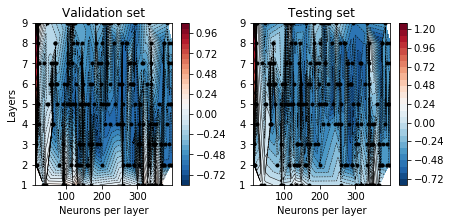

In [119]:
# ----------
# Tricontour
# ----------
# Directly supply the unordered, irregularly spaced coordinates
# to tricontour.

# Data to plot
x = record_loss.loc[:,"nb_neurons"]
y = record_loss.loc[:,"nb_layers"]
z = record_loss.loc[:,"loss_ag_valid"]
z2 = record_loss.loc[:,"loss_ag_test"]

# Figure
fig = plt.figure(figsize=(6.4,3.2))

# Valid
ax = plt.subplot(1,2,1)
ax.tricontour(x, y, np.log10(z), levels=30, linewidths=0.5, colors='k')
cntr = ax.tricontourf(x, y, np.log10(z), levels=30, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax)

# Test
ax2 = plt.subplot(1,2,2)
ax2.tricontour(x, y, np.log10(z2), levels=30, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, np.log10(z2), levels=30, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax2)

# Where are the points made?
ax.plot(x,y,"k.")
ax2.plot(x,y,"k.")

# Labels
ax.set_xlabel("Neurons per layer")
ax2.set_xlabel("Neurons per layer")
ax.set_ylabel("Layers")

# Titles
ax.set_title('Validation set')
ax2.set_title('Testing set')

plt.tight_layout()

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


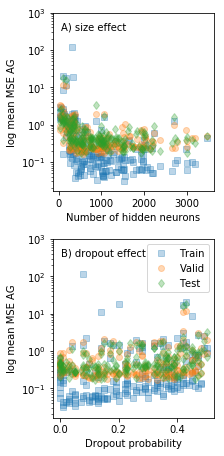

In [117]:
plt.figure(figsize=(3.22,6.44))

plt.subplot(2,1,1)
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_train"],"s",alpha=0.3,color="C0")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_valid"],"o",alpha=0.3,color="C1")
plt.plot(record_loss.loc[:,"nb_neurons"]*record_loss.loc[:,"nb_layers"],record_loss.loc[:,"loss_ag_test"],"d",alpha=0.3,color="C2")
plt.yscale('log')

plt.ylim(-2,1000)

plt.xlabel("Number of hidden neurons")
plt.ylabel("log mean MSE AG")
           
plt.annotate("A) size effect",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,1,2)
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_train"],"s",color="C0",alpha=0.3,label="Train")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_valid"],"o",color="C1",alpha=0.3,label="Valid")
plt.plot(record_loss.loc[:,"p_drop"],record_loss.loc[:,"loss_ag_test"],"d",color="C2",alpha=0.3,label="Test")
plt.yscale('log')

plt.ylim(-2,1000)

plt.annotate("B) dropout effect",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

plt.xlabel("Dropout probability")
plt.ylabel("log mean MSE AG")

plt.tight_layout()